## Work
1. 試比較 save_best_only 與否的差異
Ans:設為否 則會存 最後一個epoch的 model參數
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [5]:
import os
import keras

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC' #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
config.gpu_options.per_process_gpu_memory_fraction = 0.3
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config)) 

In [6]:
train, test = keras.datasets.cifar10.load_data()

In [7]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [8]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [9]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [22]:
"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
SAVE_ENABLE = [False,True]

In [29]:
# 載入 Callbacks
"""Code Here
設定 callbacks: model checkpoint
"""
from keras.callbacks import ModelCheckpoint

results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

for save_para in SAVE_ENABLE:

    if save_para==True:
        model_ckpt = ModelCheckpoint(filepath="./tmp.h5", 
                                     monitor="val_loss", 
                                     save_weights_only=save_para)
    else:
        model_ckpt = ModelCheckpoint(filepath="./tmp_false.h5", 
                                     monitor="val_loss", 
                                     save_weights_only=save_para)
        
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[model_ckpt]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    exp_name_tag = "exp-SAVE_BEST_ENABLE-%d" % (save_para)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
    


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_31 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_32 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_33 (Batc (None, 128)               512       
__________

Epoch 50/50
50000/50000 [==============================] - 2s 39us/step - loss: 0.4997 - acc: 0.8600 - val_loss: 1.6735 - val_acc: 0.4873
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_34 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_35 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
____

Epoch 49/50
50000/50000 [==============================] - 2s 39us/step - loss: 0.4956 - acc: 0.8608 - val_loss: 1.7038 - val_acc: 0.4888
Epoch 50/50
50000/50000 [==============================] - 2s 39us/step - loss: 0.4807 - acc: 0.8667 - val_loss: 1.6899 - val_acc: 0.4864


In [30]:
# Load back
model2 = build_mlp(input_shape=x_train.shape[1:])
optimizer2 = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model2.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer2)
model2.load_weights("./tmp.h5")
loss_loadback, acc_loadback = model2.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 144us/step


In [31]:
results

{'exp-SAVE_BEST_ENABLE-0': {'train-loss': [2.2063867319107056,
   1.75970782497406,
   1.6293701767730713,
   1.5549656649780272,
   1.5005724657821655,
   1.45493882396698,
   1.4148247705078125,
   1.3787369291687013,
   1.3462085456085204,
   1.3158057585144043,
   1.2857287178039551,
   1.258254921951294,
   1.2331816219711305,
   1.2086251104736327,
   1.181835884666443,
   1.1577401945114136,
   1.1350141438674928,
   1.1125115280151368,
   1.089630432472229,
   1.0664293621063232,
   1.045880947341919,
   1.0246816548156739,
   1.002876080646515,
   0.9802023907470703,
   0.9597012476730347,
   0.93902400390625,
   0.9198277479362488,
   0.8997431886482239,
   0.8810360378074646,
   0.8606850087738037,
   0.8401976591682434,
   0.8196259240722656,
   0.8011097183799744,
   0.7820831209373474,
   0.7634378819656372,
   0.7432783317565917,
   0.7251317057800293,
   0.7070688754844665,
   0.6886354076385498,
   0.6701507870674134,
   0.6518416848945617,
   0.6339910623550415,
   0.

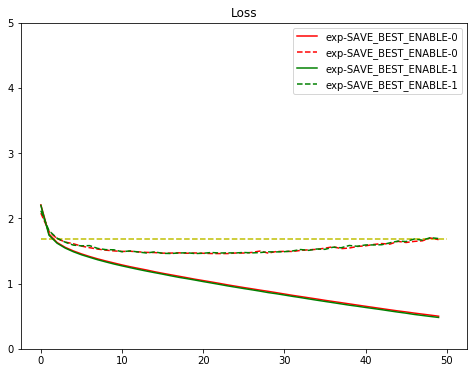

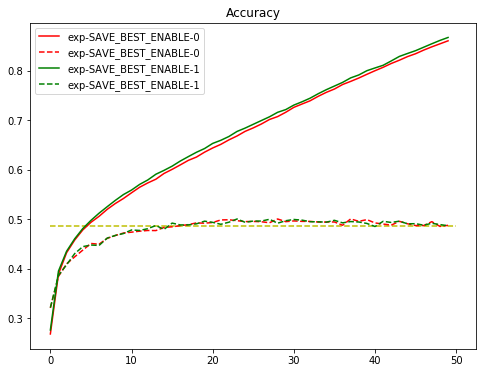

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k","black",'gray','pink']

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    if i<9:
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.hlines(y=loss_loadback, xmin=0, xmax=len(results[cond]['train-loss']), colors='y', linestyles='--')
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    if i<9:
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.hlines(y=acc_loadback, xmin=0, xmax=len(results[cond]['train-acc']), colors='y', linestyles='--')
plt.title("Accuracy")
plt.legend()
plt.show()